### Using LightGBM to predict the yield for a trade from reference data

Version dated August 5, 2021, most recently edited by Charles Elkan.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 400)

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import os
import numpy as np
from google.cloud import bigquery

from lightgbm import LGBMRegressor
import lightgbm

from collections import Counter

tqdm.pandas()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../eng-reactor-287421-112eb767e1b3.json"

Above, we ignore warnings that a dataframe is excessively fragmented. Operations on such a dataframe are slower,
but they are not a bottleneck overall. 
The _reload_ operation below activates changes in the functions defined in _prices.py_.

In [2]:
import prices
import importlib
importlib.reload(prices)

loading prices module
loading prices module


<module 'prices' from '/Users/elkan/ficc/notebooks/prices.py'>

The following transformations make trade records more readable. Note that many of the coupon frequencies occur rarely or even never in the data.
In particular, the coupon frequency is every six months for over 95% of trades.
The function _transform_ keeps the number of records unchanged, operating in-place on its argument.
Also note that performing the coupon frequency mapping twice is incorrect.

In [3]:
COUPON_FREQUENCY_DICT = {0:None,
                         1:2,      # two payments per year
                         2:12,
                         3:1,
                         4:52,
                         5:4,
                         6:1/2,
                         7:1/3,
                         8:1/4,
                         9:1/5,
                         10:1/7,
                         11:1/8,
                         12:26,
                         13:None,
                         14:360,
                         16:0,
                         17:24,
                         23:None,
                         31:None}

def transform(df):
    df['interest_payment_frequency'] = df['interest_payment_frequency'].map(COUPON_FREQUENCY_DICT)
    
    prices = ['coupon_rate', 'par_traded', 'dollar_price', 'next_call_price', 'par_call_price', 'refund_price']
    for field in prices: df[field] = df[field].astype(float)
        
    dates = ['trade_date', 'dated_date', 'settlement_date', 'first_coupon_date', 
              'next_call_date', 'par_call_date', 'refund_date', 'maturity_date']
    for field in dates: df[field] = pd.to_datetime(df[field])
    return df

The SQL query below uses the flat table that is the output of a team member's pipelines. 
No trades are excluded, but we only take the most recent information for each trade.
For dates in the past, this query avoids some erroneous information because MSRB has published corrected trade messages.
However, there exist incorrect messages that remain permanently in the data.

Why _issue__amount_ and _issue__size_ are different is unknown.

The query below fetches the history of recent trades, called _recent_.
This is a large nested data strucure, and makes the BigQuery operation slow.
On my Macbook with 16GB of memory, I can retrieve all trades for one week, but trying to get all trades for one month causes a crash.

For each trade, we compute the price and the type of repayment date assumed to obtain this price.
An M1 MacBook Air performs about 2200 price calculations per second.

In [4]:
def get_trade_data(bqclient, first_date, last_date="", usebq=False):
    savedfile = "gbmdata.pkl"
    if last_date == "": last_date = first_date
    query = f''' SELECT
        cusip,

        num_prev_messages,
        when_issued,
        brokers_broker,
        is_alternative_trading_system AS is_ATS,
        is_non_transaction_based_compensation AS is_NTBC,
        conduit_obligor_name AS obligor,
        callable_at_cav,
        max_amount_outstanding AS issue_size,
        issue_amount,

        muni_security_type AS security_type,
        other_enhancement_type AS enhancement,
        purpose_class AS purpose,
        purpose_sub_class AS purpose_sub,
        
        coupon_type,
        make_whole_call,
        has_sink_schedule,
        default_exists,
        event_exists,
        years_to_loc_expiration AS LOC_years,
        escrow_exists,
        put_exists,
        bank_qualified,
        other_enhancement_type,
        state_tax_status,
        
        trade_date,
        trade_type,
        par_traded,
        dollar_price,
        yield,
        yield_spread,
        coupon AS coupon_rate,
        interest_payment_frequency,
        dated_date,
        settlement_date, 
        first_coupon_date,
        is_callable,
        next_call_date,
        next_call_price,
        par_call_date,
        par_call_price,
        is_called,
        called_redemption_type AS redemption_type,
        refund_date,
        refund_price,
        maturity_date,
        sp_long AS rating,
        organization_primary_name AS issuer,
        is_lop_or_takedown AS is_LOPT,
        incorporated_state_code AS state,
        security_description AS description,
        instrument_primary_name AS primary,
        is_general_obligation AS is_GO,
        capital_type,
        use_of_proceeds,
        federal_tax_status AS tax_status,
        
        recent
        
        FROM `eng-reactor-287421.primary_views.trade_history_with_reference_data`
        WHERE MSRB_valid_to_date > current_date
        AND trade_date BETWEEN '{first_date}' AND '{last_date}'
        ORDER BY trade_date ASC
     '''
    
    if usebq:
        print("getting data from BigQuery")
        df = bqclient.query(query).result().to_dataframe()
        df.to_pickle(savedfile)     
        df['alert'] = False
        df = transform(df)
        df['my_price'], df['my_date'] = zip(*df.progress_apply(lambda x: prices.compute_price(x),axis=1))
        df.to_pickle(savedfile)     
    else:
        if os.path.isfile(savedfile):
            print("getting pickled data from " + savedfile)
            df = pd.read_pickle(savedfile)
        else:
            print("cannot find saved data at " + savedfile)
            df = None
    return df 

In [6]:
bqclient = bigquery.Client()
%time vanilla = get_trade_data(bqclient, '2021-01-04', '2021-01-10', usebq=False)
len(vanilla)

getting pickled data from gbmdata.pkl
CPU times: user 3.71 s, sys: 1.39 s, total: 5.1 s
Wall time: 5.77 s


154700

The following function extracts four pieces of information about the single most recent previous trade.
The method named _iloc_ is more reliable than other approaches for getting a single row from a pandas dataframe.

In [7]:
def latestys(x):
    r = x.recent[0]
    spread = r.get('yield_spread', None)
    size = r.get('par_traded', None)
    if not size is None: size = float(size)
    side = r.get('trade_type', None)
    back = r.get('seconds_ago', None)
    return spread, size, side, back

latestys(vanilla.iloc[1,:])

(-0.4655805077942101, 25000.0, 'S', 521833)

In [8]:
%time vanilla['prevys'], vanilla['prevsize'], vanilla['side'], vanilla['back'] = zip(*vanilla.apply(latestys, axis=1))

CPU times: user 3.62 s, sys: 413 ms, total: 4.04 s
Wall time: 4.34 s


The following function extends a dataframe by creating new Boolean columns for the _n_ most frequent words appearing in strings in the column named _col_.
Each of these words becomes a new binary feature whose name indicates where it comes from.

In [9]:
def extend(df, col, n = 100):
    conc = ', '.join( filter(None, df[col]) )
    conc = filter( lambda x:x.isalnum() and len(x) >= 3, conc.split() )
    conc = Counter(conc).most_common(n)
    NEWB = []
    j = 1
    for (s, _) in conc:
        newcol = f'{col}_{j}_{s}'
        df[newcol] = df[col].str.contains(f' {s}', regex=False)
        NEWB += [newcol]
        j += 1
    return df, NEWB

In [10]:
%time vanilla, issuerB = extend(vanilla, 'issuer', 100)
%time vanilla, primaryB = extend(vanilla, 'primary', 100)
%time vanilla, descB = extend(vanilla, 'description', 100)
%time vanilla, obligorB = extend(vanilla, 'obligor', 100)

CPU times: user 2.13 s, sys: 26.2 ms, total: 2.15 s
Wall time: 2.15 s
CPU times: user 1.92 s, sys: 20.4 ms, total: 1.94 s
Wall time: 1.94 s
CPU times: user 2.37 s, sys: 17.4 ms, total: 2.39 s
Wall time: 2.39 s
CPU times: user 784 ms, sys: 16.5 ms, total: 800 ms
Wall time: 800 ms


Dates are converted into durations, measured in years or days.
Bonds with deferred interest are a superset of zero-coupon bonds.

In [11]:
def period(p): return p.dt.days / 365.25

vanilla['yrs_to_call'] = period(vanilla.next_call_date - vanilla.settlement_date)
vanilla['yrs_to_par_call'] = period(vanilla.par_call_date - vanilla.settlement_date)
vanilla['yrs_to_maturity'] = period(vanilla.maturity_date - vanilla.settlement_date)
vanilla['call_to_maturity'] = period(vanilla.maturity_date - vanilla.next_call_date)

vanilla['days_to_settle'] = period(vanilla.settlement_date - vanilla.trade_date) * 365.25 
vanilla['days_to_refund'] = period(vanilla.refund_date - vanilla.settlement_date) * 365.25

vanilla['zerocoupon'] = vanilla.coupon_rate == 0
vanilla['deferred'] = (vanilla.interest_payment_frequency == 0) | vanilla.zerocoupon

In [12]:
sum(~vanilla.deferred & vanilla.zerocoupon)

0

The column _yrs__to__end_ is used later to identify the largest errors, and to give weights to training examples,
but it is not used for training, so it does not need to be known in production.
The function _end__date_ duplicates code from _prices.py_, which it should not do.

In [13]:
def end_date(trade):
    if trade.my_date == "refunding": 
        if pd.isnull(trade.refund_date):
            if trade.redemption_type in [1,5]:
                d = trade.maturity_date
            else:
                d = trade.next_call_date
        else:
            d = trade.refund_date
    elif trade.my_date == "next call": d = trade.next_call_date
    elif trade.my_date == "par call":  d = trade.par_call_date
    elif trade.my_date == "maturity":  d = trade.maturity_date
    else: d = None
    return d

%time vanilla['last_date'] = vanilla.apply(end_date, axis=1)
vanilla['yrs_to_end'] = period(vanilla.last_date - vanilla.settlement_date)

CPU times: user 5.23 s, sys: 355 ms, total: 5.59 s
Wall time: 5.61 s


We exclude bonds with unreliable data, i.e., bonds whose price cannot be reproduced or whose yield is unrealistically small or large.

In [14]:
def prune(df, keep):
    denom = len(vanilla)
    num = sum(keep)
    print("removed", denom-num, "from", denom, "kept", 100*num/denom, "%")
    return df[keep]

vanilla['price_delta'] = abs(vanilla.my_price - vanilla.dollar_price)
tol = 0.005
vanilla = prune(vanilla, vanilla.price_delta < tol)

# vanilla = prune(vanilla, vanilla.par_traded <= vanilla.issue_amount)
vanilla = prune(vanilla, vanilla['yield'] > 0)
vanilla = prune(vanilla, vanilla['yield'] < 8)

removed 4727 from 154700 kept 96.94440853264382 %
removed 290 from 149973 kept 99.80663186040154 %
removed 301 from 149683 kept 99.79890835966677 %


The issuer of a bond is identified by the first six characters of the cusip, and _proxy_ is a Boolean for whether the true borrower (i.e., the obligor) is different from the issuer.
This field is not used below, because it causes too much overfitting.
The size of trades over 5M is unavailable at the time of the trade, so we assume that all very large trades have size 5M.

In [15]:
vanilla['cusip6'] = vanilla.cusip.str[0:6]
vanilla['proxy'] = ~pd.isnull(vanilla.obligor)

vanilla['par_traded'] = vanilla.par_traded.clip(upper = 5e6)

We select features of three types to use for training.
Binary and categorical features are in fact treated identically.
Using only categorical and numerical features, omitting binary features, makes accuracy only very slightly worse.
Treating binary features as numerical has no impact.

The label to be predicted here is the yield spread. 
Slightly better accuracy is achieved when predicting this rather than yield to worst,
which indicates that adjusting for the yield curve is valuable.
This adjustment will be more valuable when using a longer period of training data.
However, we need to find a more accurate yield curve to use.

We can also predict dollar price directly, but it is not obvious how to adjust this for changes in the yield curve.

In [16]:
BINARY = ['is_callable', 'is_called', 'zerocoupon', 'deferred', 'is_LOPT', 'is_GO']
BINARY += ['when_issued', 'is_ATS', 'is_NTBC', 'callable_at_cav', 'proxy']
BINARY += ['make_whole_call', 'has_sink_schedule', 'default_exists', 'event_exists', 'escrow_exists', 'put_exists', 'bank_qualified']

BINARY += issuerB + primaryB + descB + obligorB

CATEGORICAL = ['trade_type', 'redemption_type', 'rating', 'state', 'capital_type', 'use_of_proceeds', 'tax_status']
CATEGORICAL += ['brokers_broker', 'security_type', 'enhancement', 'purpose', 'purpose_sub', 'side']
CATEGORICAL += ['coupon_type', 'other_enhancement_type', 'state_tax_status', 'LOC_years']

NUMERICAL = ['days_to_settle', 'yrs_to_call', 'yrs_to_par_call', 'days_to_refund', 'call_to_maturity']
NUMERICAL += ['par_traded', 'coupon_rate', 'next_call_price', 'par_call_price', 'refund_price', 'yrs_to_maturity']
NUMERICAL += ['num_prev_messages', 'issue_amount']
NUMERICAL += ['prevys', 'prevsize', 'back']

for f in BINARY + CATEGORICAL:
    vanilla[f] = vanilla[f].astype('category')

FEATURES = BINARY + CATEGORICAL + NUMERICAL
TARGET = 'yield_spread' # 'yield' # 'dollar_price' # 

# FEATURES = imp[imp.Value >= 30].Feature.tolist()

The dataset is already sorted in increasing order by trade date, so the latest 20% of the dataset is used for measuring out-of-sample accuracy, 
and the model is trained on the earlier 80%.
Training to minimize MSE yields better MAE than training to minimize MAE.

In [24]:
EVALFRAC = 0.2
train_index = int( len(vanilla) * (1-EVALFRAC) )

model = LGBMRegressor(num_iterations=300, max_depth=12, num_leaves=300, objective='mse', verbosity=-1, linear_tree=False)
%time model.fit(vanilla[FEATURES][0:train_index],vanilla[TARGET][0:train_index]), sample_weight=vanilla['yrs_to_end'][0:train_index])

%time vanilla['predicted'] = model.predict(vanilla[FEATURES])
vanilla['delta'] = vanilla[TARGET] - vanilla.predicted
evalset = vanilla[train_index:].copy()
evalset.delta.mean(), evalset.delta.abs().mean()

/Users/elkan/miniforge3/envs/tf25/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


CPU times: user 43.8 s, sys: 11.7 s, total: 55.5 s
Wall time: 7.76 s
CPU times: user 11.8 s, sys: 916 ms, total: 12.7 s
Wall time: 2.1 s


(0.010431877590829712, 0.14989879415982738)

The following figure shows how often each feature is used in the model. 
It is not clear which of these features are used so rarely that in fact they do not improve accuracy.
It is surprising that _issue__amount_ and _state_ are among the most important features.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

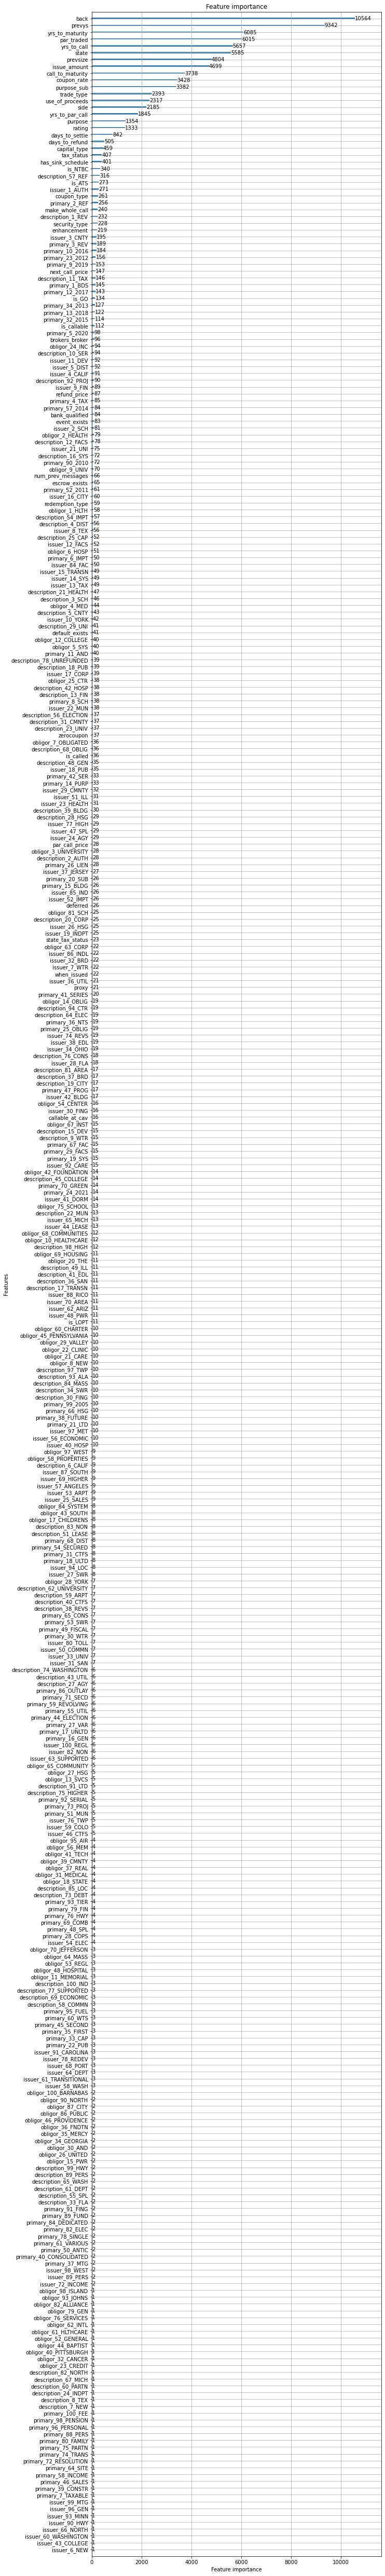

In [18]:
imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':vanilla[FEATURES].columns})
vertical = len(FEATURES)/5
lightgbm.plot_importance(model, figsize=(10,vertical))

The incremental error in dollars is approximately the incremental error in yield times the size of the trade times the duration until the bond is paid back.
However, this heuristic fails when the error in yield is large enough to change the duration,
so the large errors below for bonds with more than 20 years until redemption are over-estimates.

In [19]:
evalset['dollerr'] = evalset.delta * evalset.par_traded / 100 * evalset.yrs_to_end
evalset.sort_values('dollerr')

,cusip,num_prev_messages,when_issued,brokers_broker,is_ATS,is_NTBC,obligor,callable_at_cav,issue_size,issue_amount,security_type,enhancement,purpose,purpose_sub,coupon_type,make_whole_call,has_sink_schedule,default_exists,event_exists,LOC_years,escrow_exists,put_exists,bank_qualified,other_enhancement_type,state_tax_status,trade_date,trade_type,par_traded,dollar_price,yield,yield_spread,coupon_rate,interest_payment_frequency,dated_date,settlement_date,first_coupon_date,is_callable,next_call_date,next_call_price,par_call_date,par_call_price,is_called,redemption_type,refund_date,refund_price,maturity_date,rating,issuer,is_LOPT,state,description,primary,is_GO,capital_type,use_of_proceeds,tax_status,recent,alert,my_price,my_date,prevys,prevsize,side,back,issuer_1_AUTH,issuer_2_SCH,issuer_3_CNTY,issuer_4_CALIF,issuer_5_DIST,issuer_6_NEW,issuer_7_WTR,issuer_8_TEX,issuer_9_FIN,issuer_10_YORK,issuer_11_DEV,issuer_12_FACS,issuer_13_TAX,issuer_14_SYS,issuer_15_TRANSN,issuer_16_CITY,issuer_17_CORP,issuer_18_PUB,issuer_19_INDPT,issuer_20_CALIFORNIA,issuer_21_UNI,issuer_22_MUN,issuer_23_HEALTH,issuer_24_AGY,issuer_25_SALES,issuer_26_HSG,issuer_27_SWR,issuer_28_FLA,issuer_29_CMNTY,issuer_30_FING,issuer_31_SAN,issuer_32_BRD,issuer_33_UNIV,issuer_34_OHIO,issuer_35_METROPOLITAN,issuer_36_UTIL,issuer_37_JERSEY,issuer_38_EDL,issuer_39_MASSACHUSETTS,issuer_40_HOSP,issuer_41_DORM,issuer_42_BLDG,issuer_43_COLLEGE,issuer_44_LEASE,issuer_45_TPK,issuer_46_CTFS,issuer_47_SPL,issuer_48_PWR,issuer_49_UNIVERSITY,issuer_50_COMMN,issuer_51_ILL,issuer_52_IMPT,issuer_53_ARPT,issuer_54_ELEC,issuer_55_LOS,issuer_56_ECONOMIC,issuer_57_ANGELES,issuer_58_WASH,issuer_59_COLO,issuer_60_WASHINGTON,issuer_61_TRANSITIONAL,issuer_62_ARIZ,issuer_63_SUPPORTED,issuer_64_DEPT,issuer_65_MICH,issuer_66_NORTH,issuer_67_ILLINOIS,issuer_68_PORT,issuer_69_HIGHER,issuer_70_AREA,issuer_71_FLORIDA,issuer_72_INCOME,issuer_73_PENNSYLVANIA,issuer_74_REVS,issuer_75_CONNECTICUT,issuer_76_TWP,issuer_77_HIGH,issuer_78_REDEV,issuer_79_VIRGINIA,issuer_80_TOLL,issuer_81_TEXAS,issuer_82_NON,issuer_83_PUERTO,issuer_84_FAC,issuer_85_IND,issuer_86_INDL,issuer_87_SOUTH,issuer_88_RICO,issuer_89_PERS,issuer_90_HWY,issuer_91_CAROLINA,issuer_92_CARE,issuer_93_MINN,issuer_94_LOC,issuer_95_WISCONSIN,issuer_96_GEN,issuer_97_MET,issuer_98_WEST,issuer_99_MTG,issuer_100_REGL,primary_1_BDS,primary_2_REF,primary_3_REV,primary_4_TAX,primary_5_2020,primary_6_IMPT,primary_7_TAXABLE,primary_8_SCH,primary_9_2019,primary_10_2016,primary_11_AND,primary_12_2017,primary_13_2018,primary_14_PURP,primary_15_BLDG,primary_16_GEN,primary_17_UNLTD,primary_18_ULTD,primary_19_SYS,primary_20_SUB,primary_21_LTD,primary_22_PUB,primary_23_2012,primary_24_2021,primary_25_OBLIG,primary_26_LIEN,primary_27_VAR,primary_28_COPS,primary_29_FACS,primary_30_WTR,primary_31_CTFS,primary_32_2015,primary_33_CAP,primary_34_2013,primary_35_FIRST,primary_36_NTS,...,description_17_TRANSN,description_18_PUB,description_19_CITY,description_20_CORP,description_21_HEALTH,description_22_MUN,description_23_UNIV,description_24_INDPT,description_25_CAP,description_26_CALIFORNIA,description_27_AGY,description_28_HSG,description_29_UNI,description_30_FING,description_31_CMNTY,description_32_SALES,description_33_FLA,description_34_SWR,description_35_OHIO,description_36_SAN,description_37_BRD,description_38_REVS,description_39_BLDG,description_40_CTFS,description_41_EDL,description_42_HOSP,description_43_UTIL,description_44_METROPOLITAN,description_45_COLLEGE,description_46_JERSEY,description_47_MASSACHUSETTS,description_48_GEN,description_49_ILL,description_50_DORM,description_51_LEASE,description_52_PWR,description_53_TPK,description_54_IMPT,description_55_SPL,description_56_ELECTION,description_57_REF,description_58_COMMN,description_59_ARPT,description_60_PARTN,description_61_DEPT,description_62_UNIVERSITY,description_63_ANGELES,description_64_ELEC,description_65_WASH,description_66_LOS,description_67_MICH,description_68_OBLIG,description_69_ECONOMIC,desc

Next, we look at errors for various subsets of trades. Errors for when-issued trades are larger,
likely because these trades have no trade history available.

In [20]:
def study(col):
    print( len(col), col.abs().mean() )
    print( col.min(), col.mean(), col.std(), col.max(), "\n" )
    
study( evalset.delta )
study( evalset[evalset.when_issued].delta )
study( evalset[ evalset.when_issued == False ].delta )

29877 0.14822458704407607
-5.49964309197039 0.006743492170198204 0.30249793838698524 6.075657603326862 

2268 0.16681268574015345
-0.6673800494028099 0.0887851047356662 0.22162238572425821 1.052690679122279 

27609 0.1466976281595564
-5.49964309197039 4.009490692193582e-06 0.3072306019229109 6.075657603326862 



Next we plot actual and predicted values for the trades with largest dollar error.

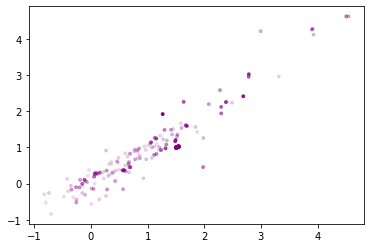

In [21]:
from matplotlib.colors import to_rgb, to_rgba
threshold = 3e5

# plot points with transparency depending on size of trade
def drawpoints(target, preds, tdf):
    #Only draw Dealer-Dealer trades
    r, g, b = to_rgb('purple')
    keep = (tdf.dollerr.abs() > threshold/10) # save time by not plotting points that would be invisible
    keep = keep & ~pd.isnull(tdf.rating)
    w = np.minimum( np.array(tdf.dollerr[keep].abs()), threshold)
    opacity = w/threshold
    color = [(r, g, b, alpha) for alpha in opacity]
    plt.scatter(target[keep], preds[keep], s=8, c=color)
    
plt.figure()
drawpoints(evalset[TARGET], evalset.predicted, evalset)

The largest cluster of large errors is for many when-issued trades from issuer 64577X, which is 
New Jersey Economic Development Authority School Facilities Construction Bonds 2021 Series QQQ.
The actual yield of these is much higher than our prediction.

In [22]:
anom = (evalset[TARGET] > 1.5) & (evalset.predicted < 1) & (evalset.dollerr.abs() > 1.3e5)
evalset[anom]

,cusip,num_prev_messages,when_issued,brokers_broker,is_ATS,is_NTBC,obligor,callable_at_cav,issue_size,issue_amount,security_type,enhancement,purpose,purpose_sub,coupon_type,make_whole_call,has_sink_schedule,default_exists,event_exists,LOC_years,escrow_exists,put_exists,bank_qualified,other_enhancement_type,state_tax_status,trade_date,trade_type,par_traded,dollar_price,yield,yield_spread,coupon_rate,interest_payment_frequency,dated_date,settlement_date,first_coupon_date,is_callable,next_call_date,next_call_price,par_call_date,par_call_price,is_called,redemption_type,refund_date,refund_price,maturity_date,rating,issuer,is_LOPT,state,description,primary,is_GO,capital_type,use_of_proceeds,tax_status,recent,alert,my_price,my_date,prevys,prevsize,side,back,issuer_1_AUTH,issuer_2_SCH,issuer_3_CNTY,issuer_4_CALIF,issuer_5_DIST,issuer_6_NEW,issuer_7_WTR,issuer_8_TEX,issuer_9_FIN,issuer_10_YORK,issuer_11_DEV,issuer_12_FACS,issuer_13_TAX,issuer_14_SYS,issuer_15_TRANSN,issuer_16_CITY,issuer_17_CORP,issuer_18_PUB,issuer_19_INDPT,issuer_20_CALIFORNIA,issuer_21_UNI,issuer_22_MUN,issuer_23_HEALTH,issuer_24_AGY,issuer_25_SALES,issuer_26_HSG,issuer_27_SWR,issuer_28_FLA,issuer_29_CMNTY,issuer_30_FING,issuer_31_SAN,issuer_32_BRD,issuer_33_UNIV,issuer_34_OHIO,issuer_35_METROPOLITAN,issuer_36_UTIL,issuer_37_JERSEY,issuer_38_EDL,issuer_39_MASSACHUSETTS,issuer_40_HOSP,issuer_41_DORM,issuer_42_BLDG,issuer_43_COLLEGE,issuer_44_LEASE,issuer_45_TPK,issuer_46_CTFS,issuer_47_SPL,issuer_48_PWR,issuer_49_UNIVERSITY,issuer_50_COMMN,issuer_51_ILL,issuer_52_IMPT,issuer_53_ARPT,issuer_54_ELEC,issuer_55_LOS,issuer_56_ECONOMIC,issuer_57_ANGELES,issuer_58_WASH,issuer_59_COLO,issuer_60_WASHINGTON,issuer_61_TRANSITIONAL,issuer_62_ARIZ,issuer_63_SUPPORTED,issuer_64_DEPT,issuer_65_MICH,issuer_66_NORTH,issuer_67_ILLINOIS,issuer_68_PORT,issuer_69_HIGHER,issuer_70_AREA,issuer_71_FLORIDA,issuer_72_INCOME,issuer_73_PENNSYLVANIA,issuer_74_REVS,issuer_75_CONNECTICUT,issuer_76_TWP,issuer_77_HIGH,issuer_78_REDEV,issuer_79_VIRGINIA,issuer_80_TOLL,issuer_81_TEXAS,issuer_82_NON,issuer_83_PUERTO,issuer_84_FAC,issuer_85_IND,issuer_86_INDL,issuer_87_SOUTH,issuer_88_RICO,issuer_89_PERS,issuer_90_HWY,issuer_91_CAROLINA,issuer_92_CARE,issuer_93_MINN,issuer_94_LOC,issuer_95_WISCONSIN,issuer_96_GEN,issuer_97_MET,issuer_98_WEST,issuer_99_MTG,issuer_100_REGL,primary_1_BDS,primary_2_REF,primary_3_REV,primary_4_TAX,primary_5_2020,primary_6_IMPT,primary_7_TAXABLE,primary_8_SCH,primary_9_2019,primary_10_2016,primary_11_AND,primary_12_2017,primary_13_2018,primary_14_PURP,primary_15_BLDG,primary_16_GEN,primary_17_UNLTD,primary_18_ULTD,primary_19_SYS,primary_20_SUB,primary_21_LTD,primary_22_PUB,primary_23_2012,primary_24_2021,primary_25_OBLIG,primary_26_LIEN,primary_27_VAR,primary_28_COPS,primary_29_FACS,primary_30_WTR,primary_31_CTFS,primary_32_2015,primary_33_CAP,primary_34_2013,primary_35_FIRST,primary_36_NTS,...,description_17_TRANSN,description_18_PUB,description_19_CITY,description_20_CORP,description_21_HEALTH,description_22_MUN,description_23_UNIV,description_24_INDPT,description_25_CAP,description_26_CALIFORNIA,description_27_AGY,description_28_HSG,description_29_UNI,description_30_FING,description_31_CMNTY,description_32_SALES,description_33_FLA,description_34_SWR,description_35_OHIO,description_36_SAN,description_37_BRD,description_38_REVS,description_39_BLDG,description_40_CTFS,description_41_EDL,description_42_HOSP,description_43_UTIL,description_44_METROPOLITAN,description_45_COLLEGE,description_46_JERSEY,description_47_MASSACHUSETTS,description_48_GEN,description_49_ILL,description_50_DORM,description_51_LEASE,description_52_PWR,description_53_TPK,description_54_IMPT,description_55_SPL,description_56_ELECTION,description_57_REF,description_58_COMMN,description_59_ARPT,description_60_PARTN,description_61_DEPT,description_62_UNIVERSITY,description_63_ANGELES,description_64_ELEC,description_65_WASH,description_66_LOS,description_67_MICH,description_68_OBLIG,description_69_ECONOMIC,desc

The most obvious case of a prediction that is too high is for cusip 167505NG7, a bond from the Chicago school district that traded at a yield 1.112% below its most recent previous trade.

In [23]:
anom = (evalset[TARGET] < 3) & (evalset.predicted > 4) & (evalset.dollerr.abs() > 1e4)
evalset[anom]

,cusip,num_prev_messages,when_issued,brokers_broker,is_ATS,is_NTBC,obligor,callable_at_cav,issue_size,issue_amount,security_type,enhancement,purpose,purpose_sub,coupon_type,make_whole_call,has_sink_schedule,default_exists,event_exists,LOC_years,escrow_exists,put_exists,bank_qualified,other_enhancement_type,state_tax_status,trade_date,trade_type,par_traded,dollar_price,yield,yield_spread,coupon_rate,interest_payment_frequency,dated_date,settlement_date,first_coupon_date,is_callable,next_call_date,next_call_price,par_call_date,par_call_price,is_called,redemption_type,refund_date,refund_price,maturity_date,rating,issuer,is_LOPT,state,description,primary,is_GO,capital_type,use_of_proceeds,tax_status,recent,alert,my_price,my_date,prevys,prevsize,side,back,issuer_1_AUTH,issuer_2_SCH,issuer_3_CNTY,issuer_4_CALIF,issuer_5_DIST,issuer_6_NEW,issuer_7_WTR,issuer_8_TEX,issuer_9_FIN,issuer_10_YORK,issuer_11_DEV,issuer_12_FACS,issuer_13_TAX,issuer_14_SYS,issuer_15_TRANSN,issuer_16_CITY,issuer_17_CORP,issuer_18_PUB,issuer_19_INDPT,issuer_20_CALIFORNIA,issuer_21_UNI,issuer_22_MUN,issuer_23_HEALTH,issuer_24_AGY,issuer_25_SALES,issuer_26_HSG,issuer_27_SWR,issuer_28_FLA,issuer_29_CMNTY,issuer_30_FING,issuer_31_SAN,issuer_32_BRD,issuer_33_UNIV,issuer_34_OHIO,issuer_35_METROPOLITAN,issuer_36_UTIL,issuer_37_JERSEY,issuer_38_EDL,issuer_39_MASSACHUSETTS,issuer_40_HOSP,issuer_41_DORM,issuer_42_BLDG,issuer_43_COLLEGE,issuer_44_LEASE,issuer_45_TPK,issuer_46_CTFS,issuer_47_SPL,issuer_48_PWR,issuer_49_UNIVERSITY,issuer_50_COMMN,issuer_51_ILL,issuer_52_IMPT,issuer_53_ARPT,issuer_54_ELEC,issuer_55_LOS,issuer_56_ECONOMIC,issuer_57_ANGELES,issuer_58_WASH,issuer_59_COLO,issuer_60_WASHINGTON,issuer_61_TRANSITIONAL,issuer_62_ARIZ,issuer_63_SUPPORTED,issuer_64_DEPT,issuer_65_MICH,issuer_66_NORTH,issuer_67_ILLINOIS,issuer_68_PORT,issuer_69_HIGHER,issuer_70_AREA,issuer_71_FLORIDA,issuer_72_INCOME,issuer_73_PENNSYLVANIA,issuer_74_REVS,issuer_75_CONNECTICUT,issuer_76_TWP,issuer_77_HIGH,issuer_78_REDEV,issuer_79_VIRGINIA,issuer_80_TOLL,issuer_81_TEXAS,issuer_82_NON,issuer_83_PUERTO,issuer_84_FAC,issuer_85_IND,issuer_86_INDL,issuer_87_SOUTH,issuer_88_RICO,issuer_89_PERS,issuer_90_HWY,issuer_91_CAROLINA,issuer_92_CARE,issuer_93_MINN,issuer_94_LOC,issuer_95_WISCONSIN,issuer_96_GEN,issuer_97_MET,issuer_98_WEST,issuer_99_MTG,issuer_100_REGL,primary_1_BDS,primary_2_REF,primary_3_REV,primary_4_TAX,primary_5_2020,primary_6_IMPT,primary_7_TAXABLE,primary_8_SCH,primary_9_2019,primary_10_2016,primary_11_AND,primary_12_2017,primary_13_2018,primary_14_PURP,primary_15_BLDG,primary_16_GEN,primary_17_UNLTD,primary_18_ULTD,primary_19_SYS,primary_20_SUB,primary_21_LTD,primary_22_PUB,primary_23_2012,primary_24_2021,primary_25_OBLIG,primary_26_LIEN,primary_27_VAR,primary_28_COPS,primary_29_FACS,primary_30_WTR,primary_31_CTFS,primary_32_2015,primary_33_CAP,primary_34_2013,primary_35_FIRST,primary_36_NTS,...,description_17_TRANSN,description_18_PUB,description_19_CITY,description_20_CORP,description_21_HEALTH,description_22_MUN,description_23_UNIV,description_24_INDPT,description_25_CAP,description_26_CALIFORNIA,description_27_AGY,description_28_HSG,description_29_UNI,description_30_FING,description_31_CMNTY,description_32_SALES,description_33_FLA,description_34_SWR,description_35_OHIO,description_36_SAN,description_37_BRD,description_38_REVS,description_39_BLDG,description_40_CTFS,description_41_EDL,description_42_HOSP,description_43_UTIL,description_44_METROPOLITAN,description_45_COLLEGE,description_46_JERSEY,description_47_MASSACHUSETTS,description_48_GEN,description_49_ILL,description_50_DORM,description_51_LEASE,description_52_PWR,description_53_TPK,description_54_IMPT,description_55_SPL,description_56_ELECTION,description_57_REF,description_58_COMMN,description_59_ARPT,description_60_PARTN,description_61_DEPT,description_62_UNIVERSITY,description_63_ANGELES,description_64_ELEC,description_65_WASH,description_66_LOS,description_67_MICH,description_68_OBLIG,description_69_ECONOMIC,desc